In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

print("TensorFlow Version:", tf.__version__)



2025-07-03 04:56:22.012836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751518582.248970      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751518582.319791      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE_PER_REPLICA = 32
SEED = 42
DATA_DIR = '/kaggle/input/data'

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU')
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
    print('Running on GPU(s)')

print("REPLICAS: ", strategy.num_replicas_in_sync)

BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Effective batch size: {BATCH_SIZE}")

Running on GPU(s)
REPLICAS:  1
Effective batch size: 32


2025-07-03 04:56:36.234143: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
try:
    df = pd.read_csv(os.path.join(DATA_DIR, 'Data_Entry_2017.csv'))
    print("Metadata loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'Data_Entry_2017.csv' not found in '{DATA_DIR}'.")
    print("Please ensure the dataset is available and the DATA_DIR path is correct.")
    # Exit or raise an exception if the file is not found
    exit()

Metadata loaded successfully.


In [5]:
# Create a complete mapping of image filenames to their full paths 
all_image_paths = {os.path.basename(p): p for p in glob.glob(os.path.join(DATA_DIR, '**', '*.png'), recursive=True)}
df['path'] = df['Image Index'].map(all_image_paths.get)

# Drop rows with no valid image path
df = df.dropna(subset=['path'])
print(f"Found {len(df)} images with corresponding metadata.")

# Identify all unique pathology labels
all_labels = np.unique(list(chain.from_iterable(df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
# 'No Finding' is the absence of other labels, so we treat it as the baseline
all_labels = [label for label in all_labels if label!= 'No Finding']
print(f'All Labels ({len(all_labels)}): {all_labels}')
# Create multi-hot encoded columns for each pathology 
for label in all_labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

print("\nSample of processed DataFrame:")
print(df.head())


Found 112120 images with corresponding metadata.
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Sample of processed DataFrame:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA     

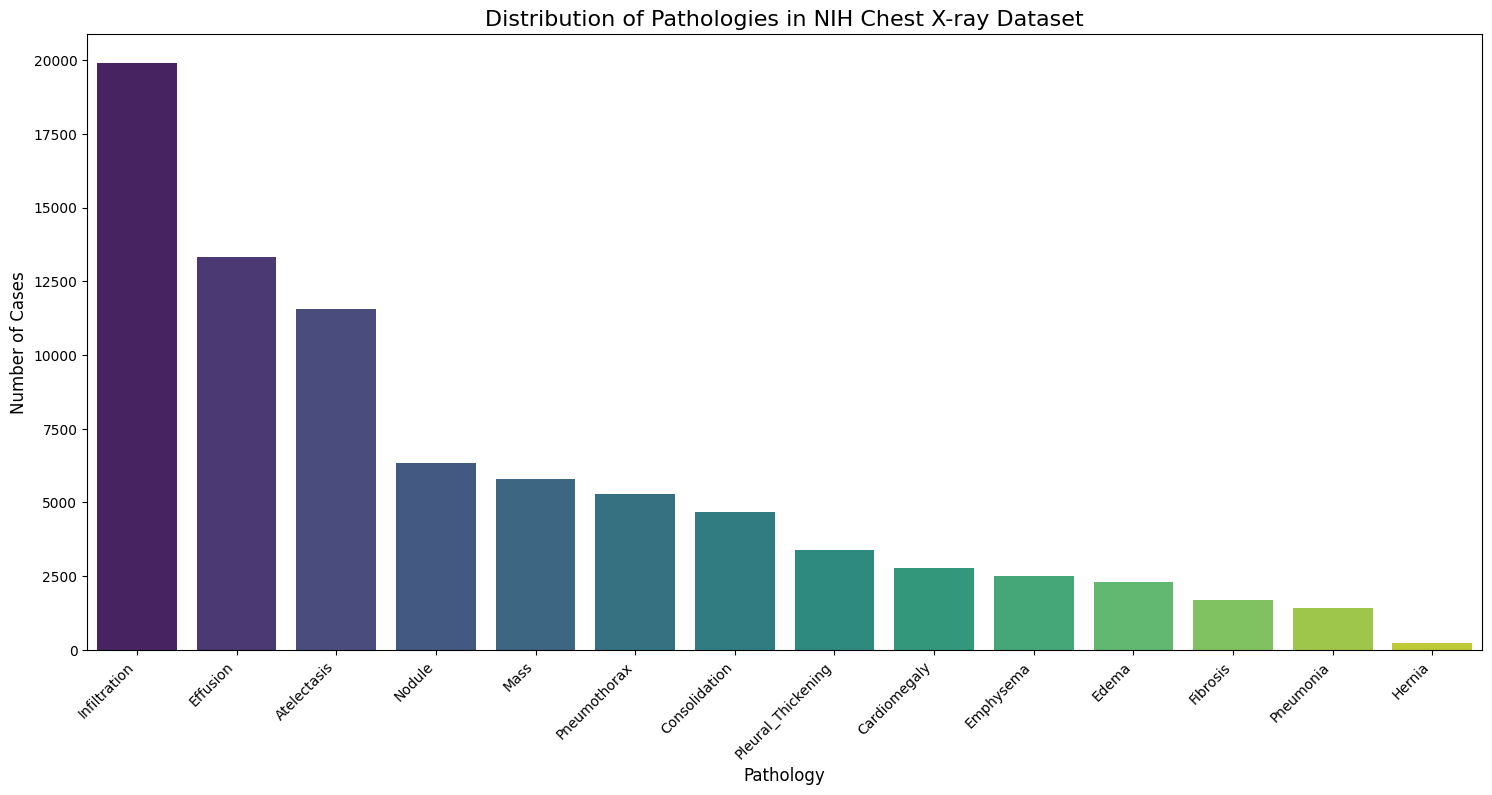


Pathology Counts:
Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64


In [6]:
pathology_counts = df[all_labels].sum().sort_values(ascending=False)

plt.figure(figsize=(18, 8))
sns.barplot(x=pathology_counts.index, y=pathology_counts.values, palette='viridis')
plt.title('Distribution of Pathologies in NIH Chest X-ray Dataset', fontsize=16)
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('Pathology', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

print("\nPathology Counts:")
print(pathology_counts)


In [7]:
from sklearn.model_selection import train_test_split

# Extract unique patient IDs
patient_ids = df['Patient ID'].unique()

# Split patient IDs: 80% for training/validation, 20% for testing
train_val_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=SEED)

# Split the first group further: 90% for training, 10% for validation
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.1, random_state=SEED)

# Create dataframes based on the patient ID splits
train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]

# Print summary
print(f"Total Patients: {len(patient_ids)}")
print(f"Train Patients: {len(train_ids)}, Validation Patients: {len(val_ids)}, Test Patients: {len(test_ids)}")
print(f"Train Samples: {len(train_df)}, Validation Samples: {len(val_df)}, Test Samples: {len(test_df)}")


Total Patients: 30805
Train Patients: 22179, Validation Patients: 2465, Test Patients: 6161
Train Samples: 80657, Validation Samples: 9169, Test Samples: 22294


Weights calculated successfully.
Sample Positive Weights: {'Atelectasis': '4.85', 'Cardiomegaly': '20.75', 'Consolidation': '12.01', 'Edema': '24.86', 'Effusion': '4.14'}
Sample Negative Weights: {'Atelectasis': '0.56', 'Cardiomegaly': '0.51', 'Consolidation': '0.52', 'Edema': '0.51', 'Effusion': '0.57'}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


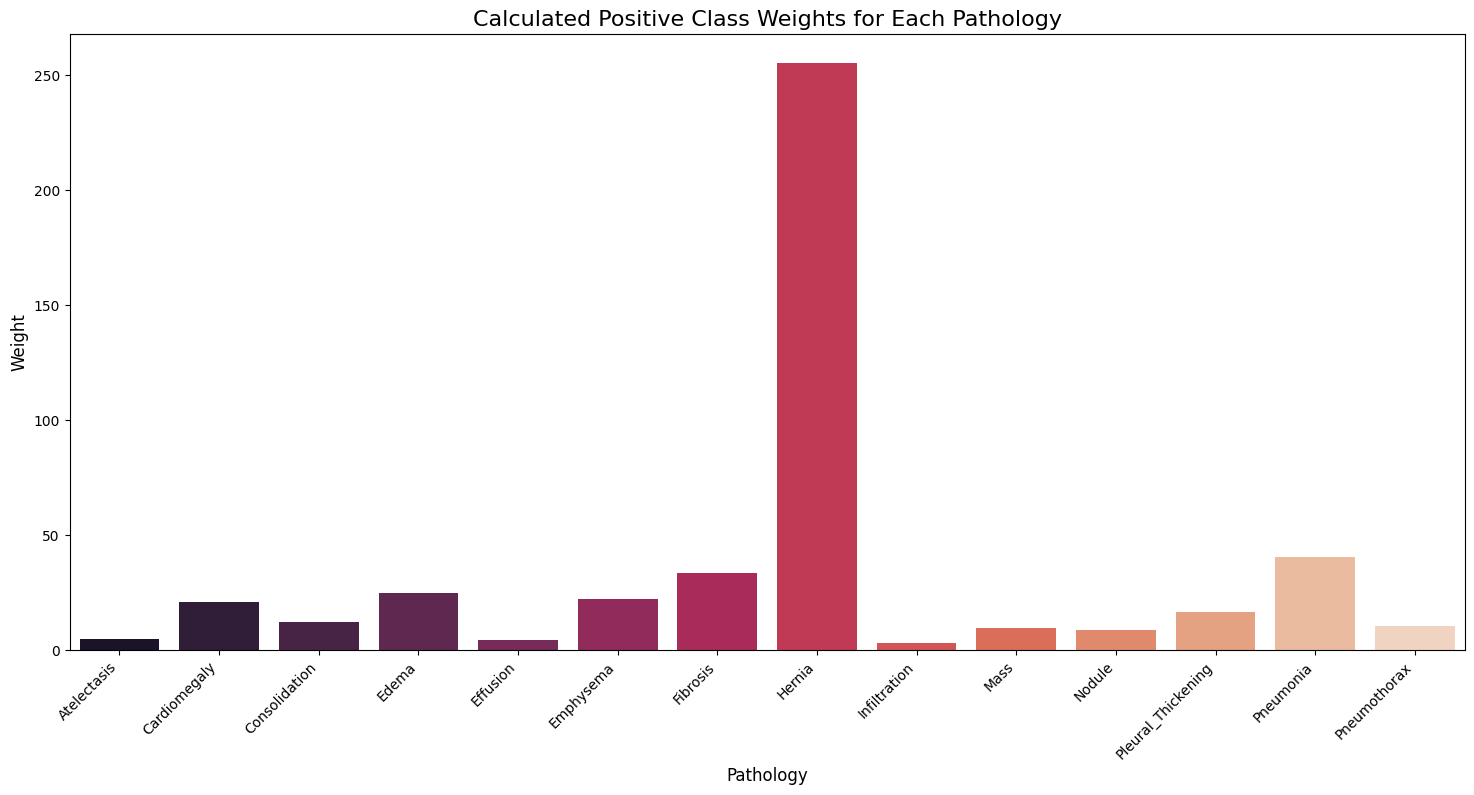

In [8]:
# We calculate class weights from the TRAINING SET ONLY to avoid data leakage.
# These weights will be used in a custom loss function to penalize errors
# on minority classes more heavily.

# Count positive and negative cases for each class in the training set
pos_counts = train_df[all_labels].sum()
neg_counts = len(train_df) - pos_counts

# Create a (num_classes, 2) tensor of weights
# weights[i, 1] is for the positive case of class i, weights[i, 0] is for the negative
weights = np.zeros((len(all_labels), 2))
total_samples = len(train_df)
for i, label in enumerate(all_labels):
    # Weight for the positive class
    pos_weight = (1 / pos_counts[label]) * (total_samples / 2.0)
    # Weight for the negative class
    neg_weight = (1 / neg_counts[label]) * (total_samples / 2.0)
    weights[i, 1] = pos_weight
    weights[i, 0] = neg_weight

print("Weights calculated successfully.")
print("Sample Positive Weights:", {label: f"{w:.2f}" for label, w in zip(all_labels[:5], weights[:5, 1])})
print("Sample Negative Weights:", {label: f"{w:.2f}" for label, w in zip(all_labels[:5], weights[:5, 0])})

# Visualize the positive class weights
plt.figure(figsize=(18, 8))
sns.barplot(x=all_labels, y=weights[:, 1], palette='rocket')
plt.title('Calculated Positive Class Weights for Each Pathology', fontsize=16)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Pathology', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


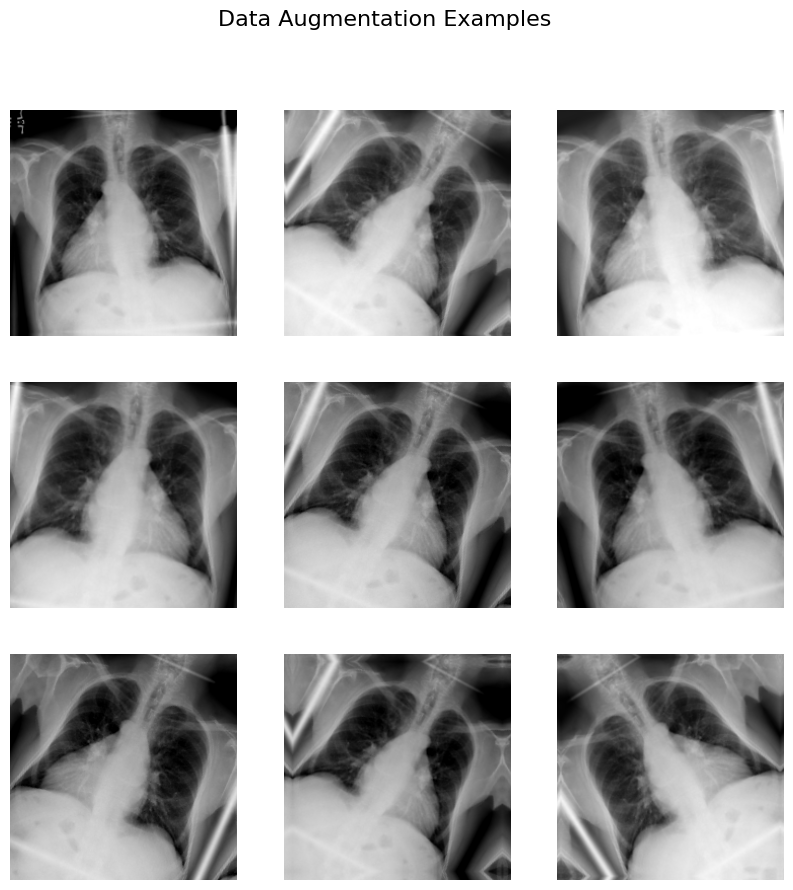

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

data_augmentation_pipeline = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
], name="data_augmentation")

# Visualize augmentation effects
sample_image_path = train_df.iloc[0]['path']
sample_image = tf.io.read_file(sample_image_path)
sample_image = tf.image.decode_png(sample_image, channels=3)

sample_image = tf.image.resize(sample_image, (224, 224))


plt.figure(figsize=(10, 10))
plt.suptitle("Data Augmentation Examples", fontsize=16)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # The data augmentation pipeline expects a batch of images.
    # tf.expand_dims adds the batch dimension.
    augmented_image_batch = data_augmentation_pipeline(tf.expand_dims(sample_image, 0), training=True)
    # We remove the batch dimension to display a single image.
    augmented_image = augmented_image_batch[0]
    # Keras layers output float tensors. For display, we might need to cast to uint8
    # if the values are not in the [0, 1] range. Normalizing to [0, 1] is safer.
    plt.imshow(augmented_image / 255.0)
    plt.axis("off")
plt.show()

In [10]:
def parse_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,size=[224, 224],method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None)

    return image, label

def create_dataset(df, augment=False):
    # This function is now simplified, augmentation is handled in the model
    # Create a dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((df['path'].values, df[all_labels].values))

    AUTOTUNE = tf.data.AUTOTUNE

    # Map the parsing function
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)

    # Configure for performance
    # NOTE: The augmentation step is removed from here
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Create the datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df, augment=False)
test_ds = create_dataset(test_df, augment=False)

print("tf.data pipelines created successfully.")


tf.data pipelines created successfully.


In [11]:
# --- Custom Weighted Loss Function ---
def get_weighted_loss(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # The core logic: multiply the loss for each class by its corresponding weight.
        # `weights[:, 1] * y_true` applies positive weight where y_true is 1.
        # `weights[:, 0] * (1 - y_true)` applies negative weight where y_true is 0.
        bce = K.binary_crossentropy(y_true, y_pred)
        loss_weights = (weights[:, 1] * y_true) + (weights[:, 0] * (1 - y_true))
        weighted_bce = loss_weights * bce
        return K.mean(weighted_bce)
    return weighted_loss

In [12]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = data_augmentation_pipeline(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(len(all_labels), activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=get_weighted_loss(weights),
        metrics=[tf.keras.metrics.AUC(name='auc_roc', multi_label=True)]
    )

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │          17,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,275,918 (8.68 MB)

 Trainable params: 17,934 (70.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Calculated Positive Weights (sample): [ 4.84659296 20.74511317 12.01325588 24.8634402   4.14092823]
Calculated Negative Weights (sample): [0.55751631 0.51234866 0.5217141  0.51026128 0.56866381]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


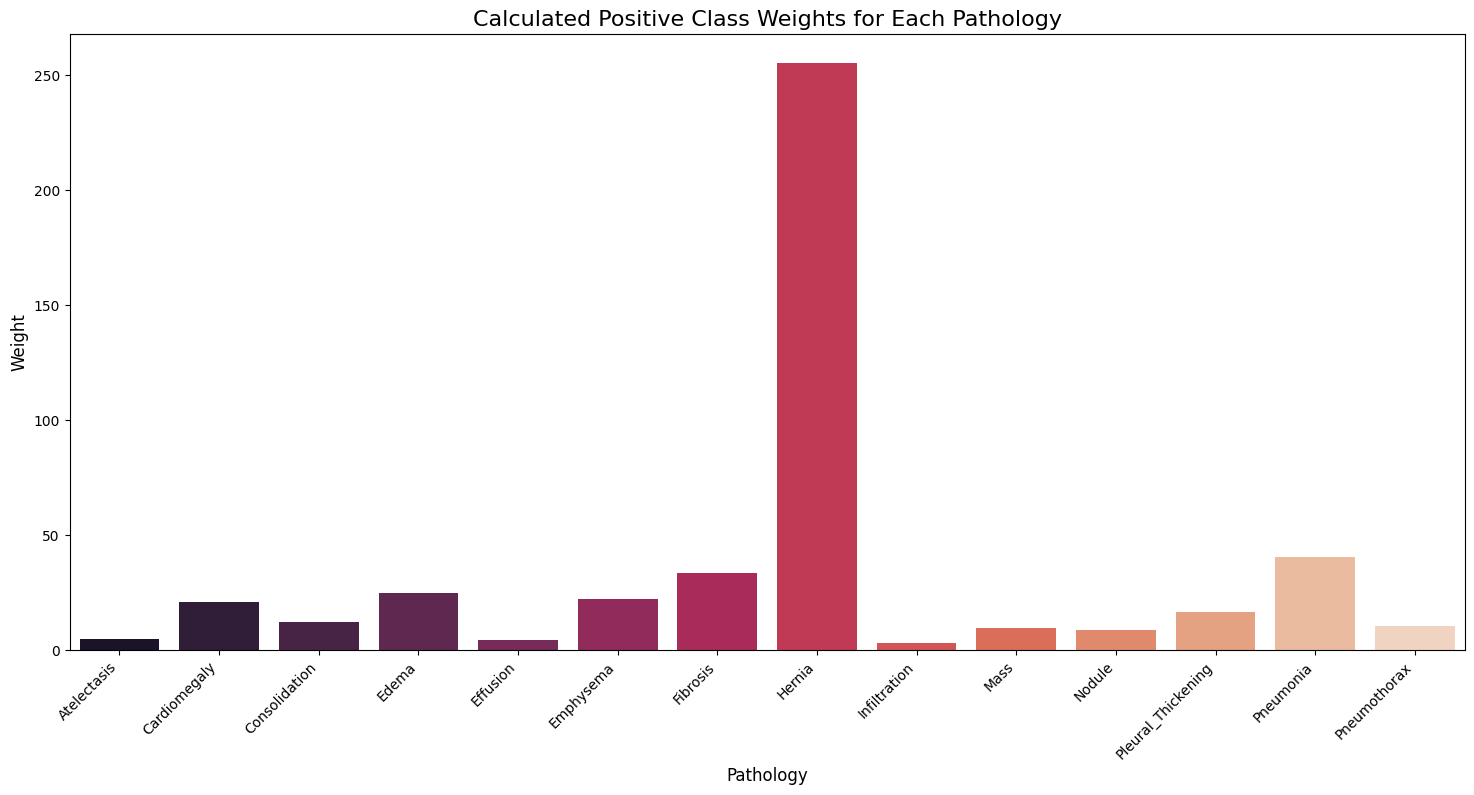

In [13]:

pos_counts = train_df[all_labels].sum()
neg_counts = len(train_df) - pos_counts

# Create a (14, 2) tensor of weights
# weights[i, 1] for positive case of class i, weights[i, 0] for negative
weights = np.zeros((len(all_labels), 2))
for i, label in enumerate(all_labels):
    pos_weight = (1 / pos_counts[label]) * (len(train_df) / 2.0)
    neg_weight = (1 / neg_counts[label]) * (len(train_df) / 2.0)
    weights[i, 1] = pos_weight
    weights[i, 0] = neg_weight

print("Calculated Positive Weights (sample):", weights[:5, 1])
print("Calculated Negative Weights (sample):", weights[:5, 0])

# Visualize the positive class weights
plt.figure(figsize=(18, 8))
sns.barplot(x=all_labels, y=weights[:, 1], palette='rocket')
plt.title('Calculated Positive Class Weights for Each Pathology', fontsize=16)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Pathology', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Custom weighted binary cross-entropy loss function [10]
def get_weighted_loss(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # The core logic: multiply the loss for each class by its corresponding weight
        # (weights[:, 1]**(y_true)) applies positive weight where y_true is 1
        # (weights[:, 0]**(1-y_true)) applies negative weight where y_true is 0
        bce = K.binary_crossentropy(y_true, y_pred)
        loss_weights = (weights[:, 1]**y_true) * (weights[:, 0]**(1-y_true))
        weighted_bce = loss_weights * bce
        return K.mean(weighted_bce)
    return weighted_loss


In [14]:
print("Starting initial training (feature extraction)...")

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'initial_training_weights.weights.h5',  
    save_weights_only=True,
    monitor='val_auc_roc',
    mode='max',
    save_best_only=True
)

checkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    'initial_training_model.keras',
    save_weights_only=False, 
    monitor='val_auc_roc',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]
)

print("Initial training complete.")


Starting initial training (feature extraction)...
Epoch 1/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc_roc: 0.5249 - loss: 0.7747

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: auc_roc,loss,val_auc_roc,val_loss
  current = self.get_monitor_value(logs)


2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2925s 1s/step - auc_roc: 0.5249 - loss: 0.7747 - val_auc_roc: 0.6316 - val_loss: 0.8605
Epoch 2/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2928s 1s/step - auc_roc: 0.5370 - loss: 0.7295 - val_auc_roc: 0.6403 - val_loss: 0.8944
Epoch 3/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2997s 1s/step - auc_roc: 0.5390 - loss: 0.7304 - val_auc_roc: 0.6522 - val_loss: 0.8080
Epoch 4/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2968s 1s/step - auc_roc: 0.5395 - loss: 0.7313 - val_auc_roc: 0.6555 - val_loss: 0.7794
Epoch 5/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3014s 1s/step - auc_roc: 0.5370 - loss: 0.7301 - val_auc_roc: 0.6611 - val_loss: 0.9093
Epoch 6/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2918s 1s/step - auc_roc: 0.5433 - loss: 0.7295 - val_auc_roc: 0.6567 - val_loss: 0.8390
Epoch 7/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2925s 1s/step - auc_roc: 0.5414 - loss: 0.7315 - val_auc_roc: 0.6562 - val_loss: 0.8380
Epoch 8/10
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 2927s 1s/step - auc_roc: 0.5446 - loss: 0.7373 - val_auc_ro

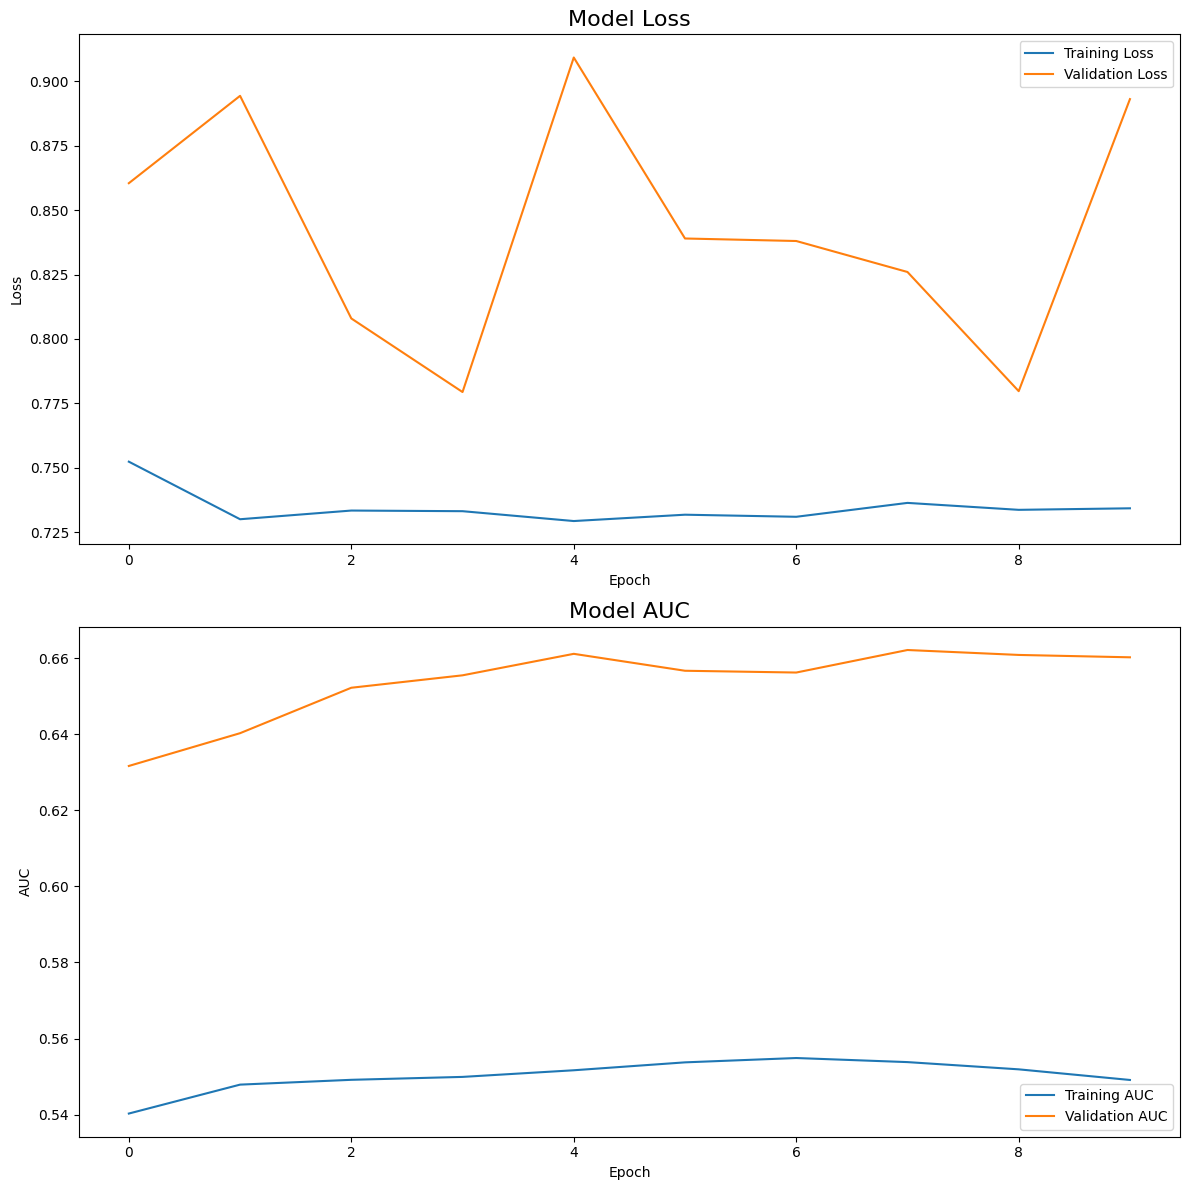

In [15]:
def plot_training_history(history):
    """Plots training and validation loss and AUC."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss', fontsize=16)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    # Plot AUC
    ax2.plot(history.history['auc_roc'], label='Training AUC')
    ax2.plot(history.history['val_auc_roc'], label='Validation AUC')
    ax2.set_title('Model AUC', fontsize=16)
    ax2.set_ylabel('AUC')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

